# Modelling of catalogue data
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we consider the modelling of a quadruply imaged (quasar) lens.

In a first step, we simulate a quad lens and compute the following mock data products:

- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties) based on a extended Gaussian surface brighness corresponding to a narrow line emission region.

In a section step, we use this mock data to sample the lens model parameter space (and optionally the quasar source size). The modelling can also be used if only partial information (e.g. no time delays and/or no flux ratio measurements) are available.

In [1]:
# import the necessary python modules
import numpy as np
import time
import corner
import json

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from astropy.cosmology import FlatLambdaCDM
import lenstronomy.Plots.output_plots as lens_plot

import matplotlib.pyplot as plt
%matplotlib inline

## Load catalogued data

In [2]:
args = {}
args["infile"] = "../../../inputs/limg_catalogs_no_los_4_b.json"
args["dt_sigma"] = 2
args["image_amps_sigma"] = 0.3
args["flux_ratio_errors"] = 0.1
args["astrometry_sigma"] = 0.004

In [3]:
with open(args["infile"], "r") as myfile:
    limg_data = myfile.read()
systems = json.loads(limg_data)

with open("../../../inputs/lens_catalogs_sie_only.json", "r") as myfile:
    limg_data = myfile.read()
systems_prior = json.loads(limg_data)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
# we chose a finite source size of the emitting
# 'point source' region Gaussian source size
# in units of parsec
source_size_pc = 10.

# we compute the finite magnification by rendering
# a grid around the point source position and add up
# all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)
z_source = 2.0
c_light = 299792.458  # in km/s


In [4]:
lensID = 203

for ii in range(len(systems))[lensID:lensID+1]:
    system = systems[ii]
    system_prior = systems_prior[ii]

    # the data set is
    z_lens = system_prior["zl"]
    
    lensCosmo = LensCosmo(
        cosmo=cosmo,
        z_lens=z_lens,
        z_source=z_source,
    )

    # convert units of pc into arcseconds
    D_s = lensCosmo.D_s
    source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec

    # multiple images properties
    ximg = np.zeros(system["nimgs"])
    yimg = np.zeros(system["nimgs"])
    t_days = np.zeros(system["nimgs"])
    image_amps = np.zeros(system["nimgs"])
    for jj in range(system["nimgs"]):
        ximg[jj] = system["ximg"][jj]        #[arcsec]
        yimg[jj] = system["yimg"][jj]        #[arcsec]
        t_days[jj] = system["delay"][jj]      #[days]
        image_amps[jj] = system["mags"][jj]  #[linear units or magnitudes]
    # sort by arrival time
    index_sort = np.argsort(t_days)
    ximg = ximg[index_sort]  # relative RA (arc seconds)
    yimg = yimg[index_sort]  # relative DEC (arc seconds)
    image_amps = np.abs(image_amps[index_sort])
    t_days = t_days[index_sort]
    d_dt = t_days[1:] - t_days[0]
    
    # measurement uncertainties
    astrometry_sigma = args["astrometry_sigma"]
    ximg_measured = ximg + np.random.normal(
        0,astrometry_sigma, system["nimgs"])
    yimg_measured = yimg + np.random.normal(
        0, astrometry_sigma, system["nimgs"])
    image_amps_sigma = np.ones(system["nimgs"]) * args["image_amps_sigma"]
    flux_ratios = image_amps[1:] - image_amps[0]
    flux_ratio_errors = np.ones(system["nimgs"] - 1) * args["flux_ratio_errors"]
    flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
    d_dt_sigma = np.ones(system["nimgs"] - 1) * args["dt_sigma"]
    d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)
    
    kwargs_data_joint = {
        'time_delays_measured': d_dt_measured,
        'time_delays_uncertainties': d_dt_sigma,
        'flux_ratios': flux_ratios_measured, 
        'flux_ratio_errors': flux_ratio_errors,
        'ra_image_list': [ximg_measured],
        'dec_image_list': [yimg_measured],
    }

## Model settings
Here we set up the modeling (initial guess of the parameters, uncertainties and lower and upper bounds. In this example, we chose the same lens model as we produced the mock data and thus expect a perfect fit.
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details.

In [5]:
# ==================
# lens model choices
# ==================
lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# SPEMD parameters
fixed_lens.append({}) 
# initial parameter guess
#kwargs_lens_init.append(kwargs_lens[0])
kwargs_lens_init.append({
    'theta_E': 1., 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0.
})
# initial particle clowd
kwargs_lens_sigma.append({
    'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1
})
# hard bound lower limit of parameters
kwargs_lower_lens.append({
    'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10
})
# hard bound upper limit of parameters
kwargs_upper_lens.append({
    'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10
})

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0)
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
#kwargs_lens_init.append(kwargs_lens[1])
kwargs_lens_init.append({'gamma_ext': 0.05, 'psi_ext': 0.0})
kwargs_lens_sigma.append({'gamma_ext': 0.05, 'psi_ext': np.pi})
kwargs_lower_lens.append({'gamma_ext': 0, 'psi_ext': -np.pi})
kwargs_upper_lens.append({'gamma_ext': 0.3, 'psi_ext': np.pi})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear)
point_source_list = ['LENSED_POSITION']
# We fix the image position coordinates.
fixed_ps = [{}]  # we fix the image position coordinates
# these lines below actually don't matter when you keep the image position fixed
# the initial guess for the appearing image positions is: at the image position.
kwargs_ps_init = [{'ra_image': ximg_measured, 'dec_image': yimg_measured}]
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(ximg)), 'dec_image': 0.01 * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# ==================
# quasar source size
# ==================

# If you want to keep the source size fixed during the fitting, outcomment the line below.
fixed_special['source_size'] = source_size_arcsec
kwargs_special_init['source_size'] = source_size_arcsec
kwargs_special_sigma['source_size'] = source_size_arcsec
kwargs_lower_special['source_size'] = 0.0001
kwargs_upper_special['source_size'] = 1

# ===================
# Time-delay distance
# ===================

# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay
# information to constrain the lens model, out-comment the line below
#fixed_special['D_dt'] = lensCosmo.D_dt
kwargs_special_init['D_dt'] = 4300    # corresponds to H0 ~ 70
kwargs_special_sigma['D_dt'] = 3000
kwargs_lower_special['D_dt'] = 2500   # corresponds to H0 ~ 120
kwargs_upper_special['D_dt'] = 14000  # corresponds to H0 ~ 20

special_params = [
    kwargs_special_init,
    kwargs_special_sigma,
    fixed_special,
    kwargs_lower_special,
    kwargs_upper_special,
]

# combined parameter settings
kwargs_params = {
    'lens_model': lens_params,
    'point_source_model': ps_params,
    'special': special_params,
}

# our model choices
kwargs_model = {
    'lens_model_list': lens_model_list, 
    'point_source_model_list': point_source_list,
}

In [6]:
kwargs_model

{'lens_model_list': ['SPEMD', 'SHEAR_GAMMA_PSI'],
 'point_source_model_list': ['LENSED_POSITION']}

## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihoods.

In [7]:
time_delay_likelihood = True  # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
flux_ratio_likelihood = True  # bool, modeling the flux ratios of the images
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_flux_compute = {'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source sice, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within the window_size around the image position
# ATTENTION: make sure that the numerical options are chosen to provide accurate computations for the finite source magnifications!


kwargs_constraints = {'num_point_source_list': [len(ximg)],  
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeld
                      'Ddt_sampling': time_delay_likelihood,  # sampling of the time-delay distance                      
                     }
if kwargs_flux_compute['source_type'] in ['GAUSSIAN', 'TORUS'] and flux_ratio_likelihood is True:
    kwargs_constraints['source_size'] = True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS') 

    
# we can define un-correlated Gaussian priors on specific parameters explicitly

# e.g. power-law mass slope of the main deflector
prior_lens = [[0, 'gamma', 2, 0.1]] # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
#prior_special = [['source_size', source_size_arcsec, 0.01]]
prior_special = []
    
kwargs_likelihood = {  
    'position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
    'source_position_likelihood': True,  # evaluates how close the different image positions match the source positons
    'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
    'time_delay_likelihood': time_delay_likelihood,  # evaluating the time-delay likelihood
    'flux_ratio_likelihood': flux_ratio_likelihood,  # enables the flux ratio likelihood 
    'kwargs_flux_compute': kwargs_flux_compute,  # source_type='INF' will lead to point source
    'prior_lens': prior_lens,
    'prior_special': prior_special,
    'check_solver': True, # check non-linear solver and disgard non-solutions
    'solver_tolerance': 0.001,
    'check_bounds': True,  # check parameter bounds and punish them
    }


## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [8]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [#['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],  # you can add additional fixed parameters if you want
    ['PSO',
     {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 500}],
]

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')



Computing the PSO ...


/usr/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
max iteration reached! stoping
-600.1918608224775 reduced X^2 of best position
-600.1918608224775 logL
2 effective number of data points
[{'theta_E': 1.4169753938472598, 'gamma': 2.4999961876794123, 'e1': -0.18271480428655315, 'e2': -0.06712749105148615, 'center_x': -0.01622875869818752, 'center_y': 0.12896381581335103}, {'gamma_ext': 0.0839020183778856, 'psi_ext': -1.3993078763437674, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.24572639,  0.3676484 ,  1.07601878, -0.84821683]), 'dec_image': array([ 1.58573616, -1.27757158, -0.75580715, -0.99270022]), 'point_amp': 1}] point source result
{'D_dt': 9999.99962664409} special param result
1022.9456868171692 time used for PSO PSO
1022.9826102256775 total time needed for computation
============ CONGR

time-delay logL = -292.69068550254525
flux ratio logL = -290.26565886254394
source position likelihood -1000000000000000
image position likelihood -4.735751739044405
Prior likelihood = -12.499809384697304


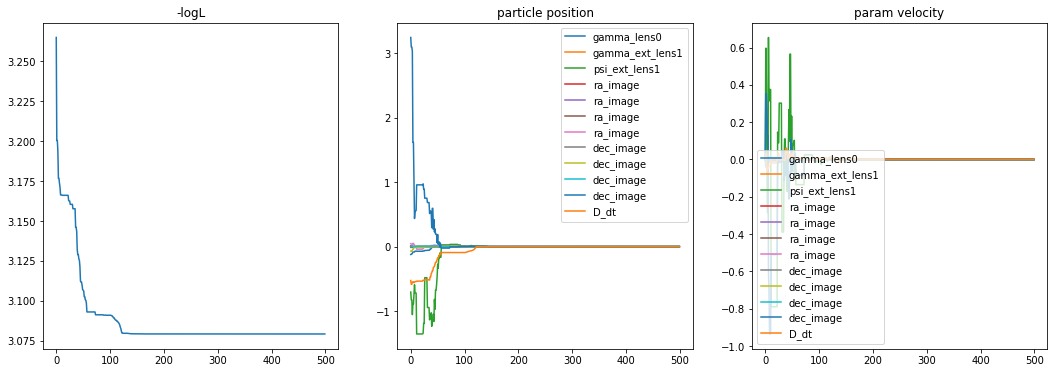

<Figure size 432x288 with 0 Axes>

In [9]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL, _ = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

from lenstronomy.Plots import output_plots as out_plot
for i in range(len(chain_list_pso)):
    out_plot.plot_chain_list(chain_list_pso, i)

## MCMC posterior sampling

In [10]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC',
     {'n_burn': 400, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the MCMC...
Number of walkers =  120
Burn-in iterations:  400
Sampling iterations: 600


/usr/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
779.9245748519897 time taken for MCMC sampling


## Post-processing the chains 

In [11]:

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])



# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel) 


mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]
if flux_ratio_likelihood is True:
    labels_new.extend(['B/A', 'C/A', 'D/A'])
if kwargs_constraints.get('source_size', False) is True:
    if 'source_size' not in fixed_special:
        labels_new.append('source size')
if time_delay_likelihood is True:
    labels_new.append(r"$D_{dt}$")
    
print(labels_new)


number of non-linear parameters in the MCMC process:  12
parameters in order:  ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  72000
['$\\theta_E$', '$\\gamma$', '$\\phi_{lens}$', '$q$', '$\\phi_{ext}$', '$\\gamma_{ext}$', 'B/A', 'C/A', 'D/A', '$D_{dt}$']


In [12]:
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_lens_out, kwargs_special_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_special'], kwargs_out['kwargs_ps']
    
    # compute 'real' image position adding potential astrometric shifts
    x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
    
    # extract quantities of the main deflector
    theta_E = kwargs_lens_out[0]['theta_E']
    gamma = kwargs_lens_out[0]['gamma']
    e1, e2 = kwargs_lens_out[0]['e1'], kwargs_lens_out[0]['e2']
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    phi_ext, gamma_ext = kwargs_lens_out[1]['psi_ext'] % np.pi, kwargs_lens_out[1]['gamma_ext']
    new_chain = [theta_E, gamma, phi, q, phi_ext, gamma_ext]
    if flux_ratio_likelihood is True:
        mag = lensModel.magnification(x_pos, y_pos, kwargs_lens_out)
        flux_ratio_fit = mag[1:]/mag[0]
        new_chain.extend([flux_ratio_fit[0], flux_ratio_fit[1], flux_ratio_fit[2]])
    if kwargs_constraints.get('source_size', False) is True and 'source_size' not in fixed_special:
        source_size = kwargs_special_out['source_size']
        new_chain.append(source_size)
    if time_delay_likelihood is True:
        D_dt = kwargs_special_out['D_dt']
        new_chain.append(D_dt)
    
    #source_size = np.random.uniform(high=1, low=0)
    mcmc_new_list.append(np.array(new_chain))

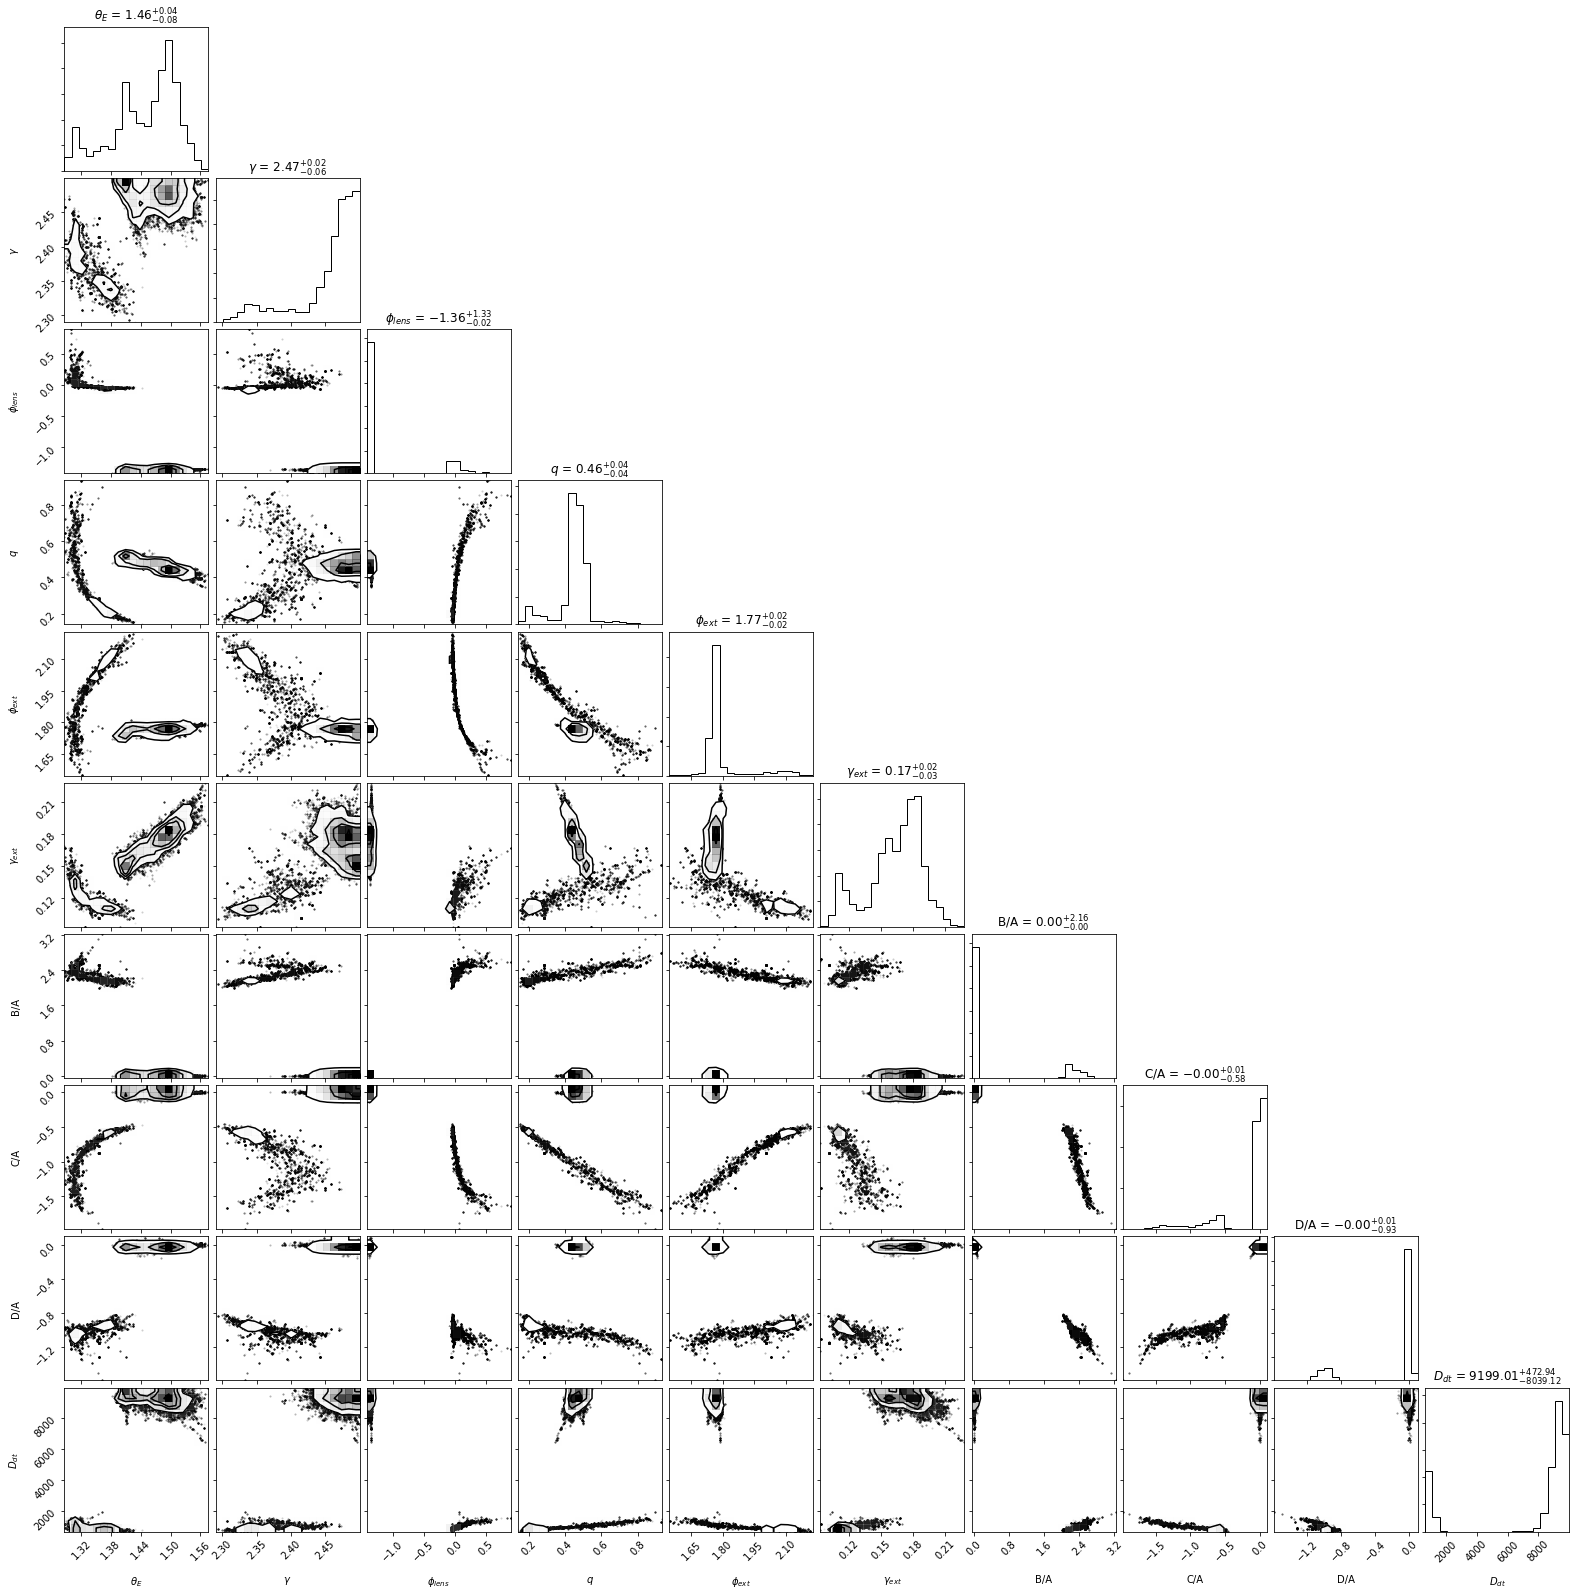

In [13]:
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

Show only selected results of corner plot

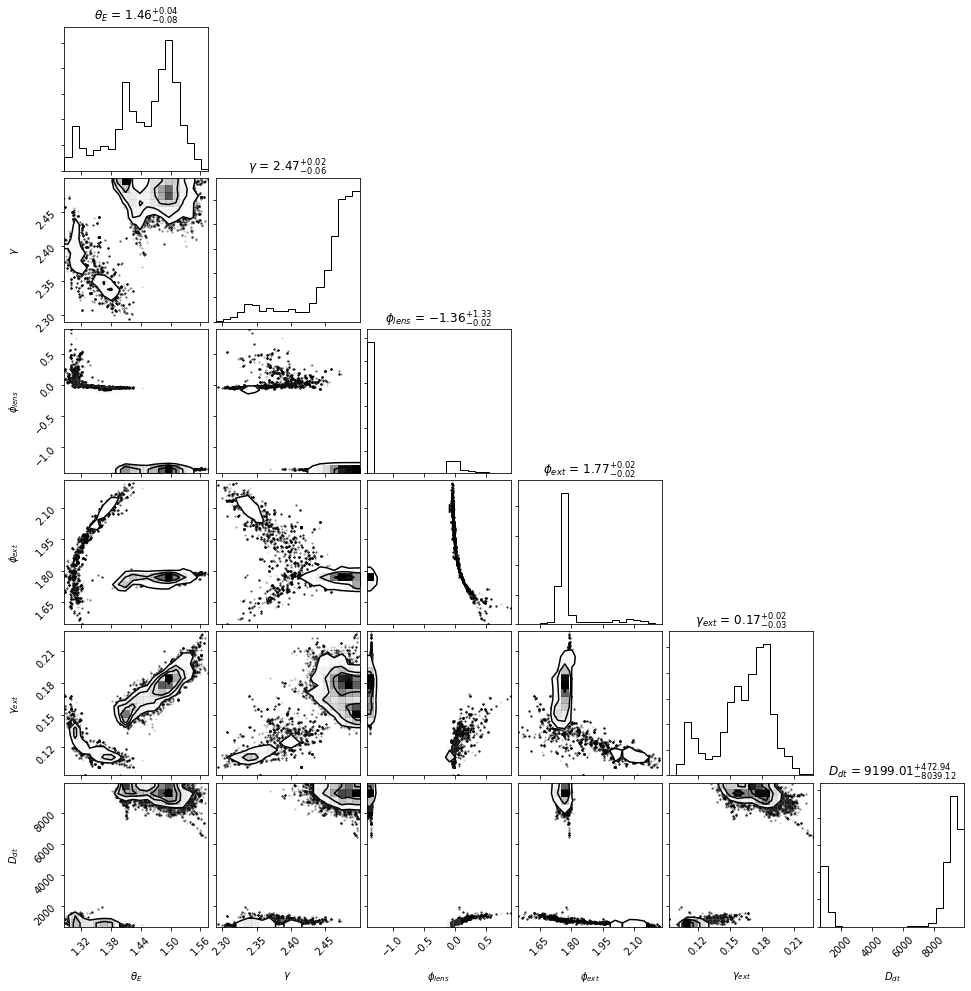

In [15]:
indx = np.asarray([0,1,2,4,5,9])
labels_new_new = np.asarray([labels_new[ii] for ii in indx])
mcmc_new_new_list = [ll[indx] for ll in mcmc_new_list]

plot = corner.corner(
    mcmc_new_new_list,
    labels=labels_new_new,
    show_titles=True,
)
plt.savefig('lenstronomy_test.png')

In [20]:
# Inferred Hubble parameter
c_light = 299792.458  # in km/s
D_dt = np.asarray([ll[-1] for ll in mcmc_new_list])
H0_median = c_light/np.mean(D_dt)
H0_median

39.04058689482929